In [1]:
import numpy as np
import matplotlib.pyplot as plt
from init_cond import *

In [2]:
def scale():
    Gcgs  = 6.667e-8   #G in cgs
    pc = 3.086e18   #pc in cgs
    msun = 1.989e33 #msun in cgs
    rsun = 6.95e10  #rsun in cgs
    AU = 1.49e13    #AU in cgs
    L_scale = 1./AU                          #1cm/1pc
    M_scale = 1./msun                        #1g/1M_sun
    T_scale = (Gcgs * L_scale**3/M_scale)**0.5  #tscale in nbody units
    V_scale = (L_scale/T_scale)              # vel in nbody units
    return (L_scale,M_scale,T_scale,V_scale)
L_scale, M_scale, T_scale, V_scale = scale()

In [3]:
print(L_scale, M_scale, T_scale, V_scale)

6.711409395973154e-14 5.027652086475616e-34 2.0021804502433981e-07 3.352050208639921e-07


In [4]:
m1 = 1.0
m2 = 1.0
m_tot = m1 + m2
a = 1.0
t = 0.0
h = 0.1
ecc = 0.90
fase = 0.0
G = 1.0

In [5]:
x_init = gen_pos(m1,m2,a,ecc,fase,G)
v_init = gen_vel(m1,m2,a,ecc,fase,G) 
b0 = G * (m1+m2) / (2*a)

x = -(x_init[0, :] - x_init[1, :])
v = -(v_init[0, :] - v_init[1, :])

In [6]:
print(x)
print(v)

[ 0.1  0.  -0. ]
[-0.        6.164414 -0.      ]


In [7]:
def g_trivial(t, x):
    return np.zeros((3))

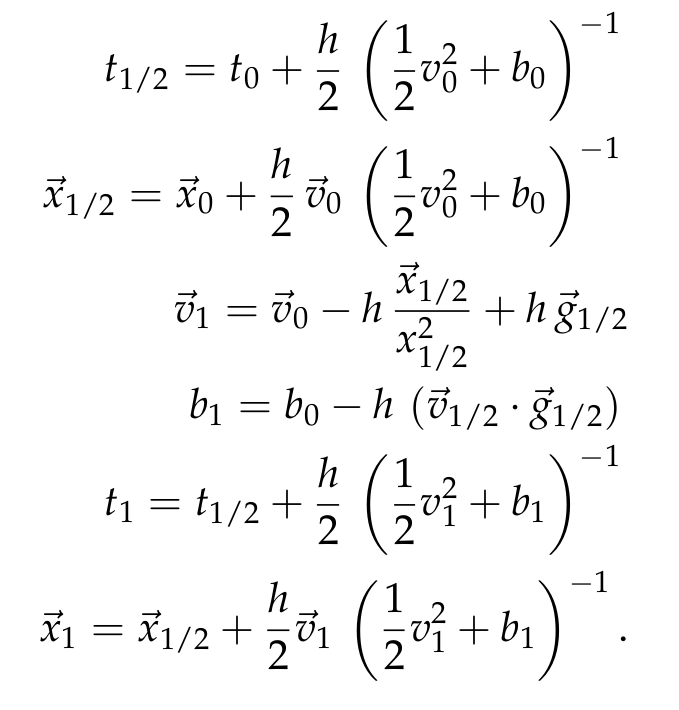

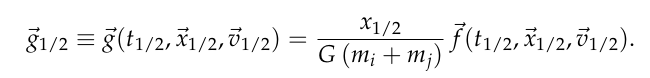

In [8]:
def verlet_dkd_step(t, x, v, b,h,g=g_trivial):
    v0_sq = np.sum(v**2)
    
    #drift
    t_half = t + (0.5 * h) / (0.5 * v0_sq + b)
    x_half = x + (0.5 * h * v) / (0.5 * v0_sq + b)
    x_half_sq = np.sum(x_half **2)
    
    #kick
    g_half = g(t_half, x_half)
    v_1 = v - h * x_half/x_half_sq + h * g_half
    v1_sq = np.sum(v_1**2)

    v_half = 0.5 * (v + v_1)
    
    # update b : trivial case
    # print(v_half.shape)
    b_1 = b - h * (v_half @ g_half)
    #print(b_1)
    
    # drift
    t_1 = t_half + (0.5 * h) / (0.5 * v1_sq + b_1)
    x_1 = x_half + (0.5 * h  * v_1) / (0.5 * v1_sq + b_1)


    E = 0.5 * np.sum(v**2) - m_tot / np.linalg.norm(x)
    return t_1, x_1, v_1, b_1, E


# Unperturbed simulation

In [9]:
x_init = gen_pos(m1,m2,a,ecc,fase,G)
v_init = gen_vel(m1,m2,a,ecc,fase,G) 
b0 = G * (m1+m2) / (2*a)

x = x_init[0, :] - x_init[1, :]
v = v_init[0, :] - v_init[1, :]

g = g_trivial
b = b0
t = 0
xs, vs, bs, ts, Es = [], [], [], [], []

t_f = 50

while t < t_f:
    t, x, v, b, E = verlet_dkd_step(t, x, v, b, h, g)
    ts.append(t)
    xs.append(x)
    vs.append(v)
    bs.append(b)
    Es.append(E)
xs = np.array(xs)
vs = np.array(vs)
ts = np.array(ts)
bs = np.array(bs)



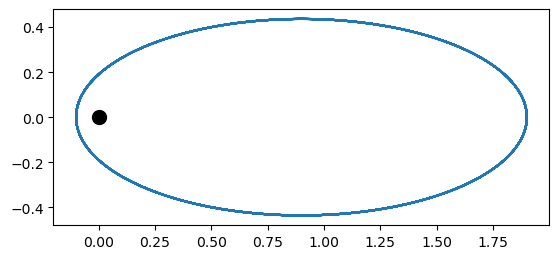

In [10]:
plt.plot(xs[:, 0], xs[:,1])
plt.scatter([0], [0], c="k", s=100)
plt.gca().set_aspect('equal')

Text(0.5, 0, 'Time')

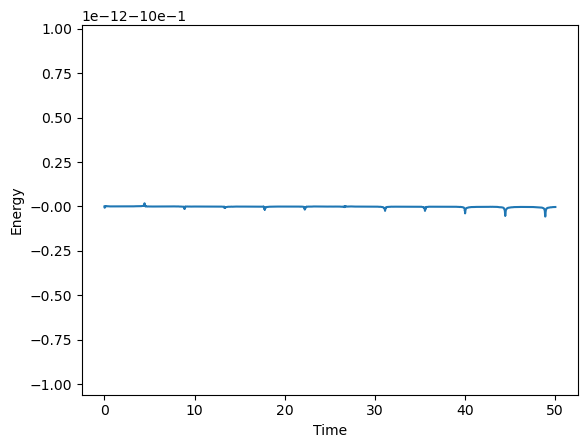

In [11]:
plt.plot(ts, Es)
plt.ylabel("Energy")
plt.xlabel("Time")

# (e) : In our simulation, the energy seems to be conserved, similar to other symplectic algorithms. 

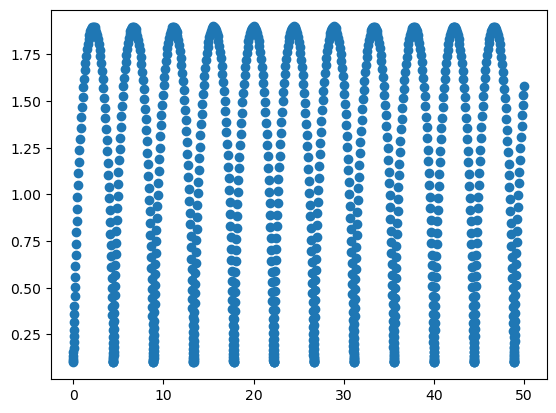

In [12]:
plt.scatter(ts, np.linalg.norm(xs, axis=1))


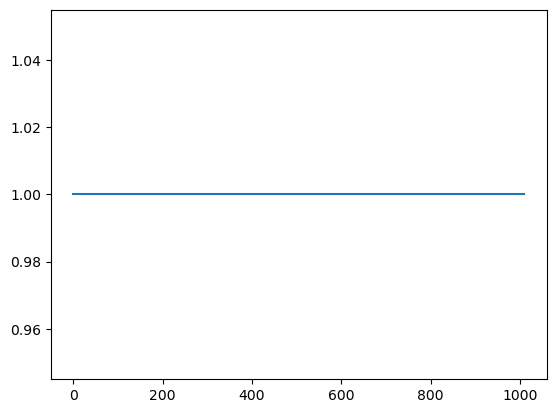

In [13]:
plt.plot(bs)
# keeping track of binding energy

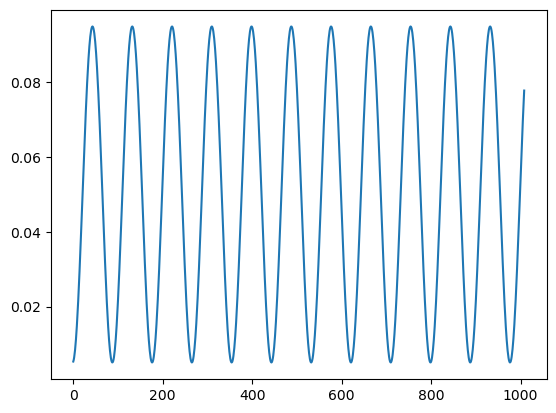

In [14]:
plt.plot(np.diff(ts))

# (d) Perturbed simulation

We saw the orbits are precessing: a torque is being applied to the system externally, and that disturbs it.
We see this result both in the Mikkola case and in the ordinary Verlet

In [15]:

x_init = gen_pos(m1,m2,a,ecc,fase,G)
v_init = gen_vel(m1,m2,a,ecc,fase,G) 
b0 = G * (m1+m2) / (2*a)

x = x_init[0, :] - x_init[1, :]
v = v_init[0, :] - v_init[1, :]

def g_perturbed(t, x):
    f = -x
    tmp = np.linalg.norm(x) / (G * m_tot) * f
    return tmp

g = g_perturbed
b = b0
t = 0
xs, vs, bs, ts = [], [], [], []

t_f = 50

while t < t_f:
    t, x, v, b, _ = verlet_dkd_step(t, x, v, b, h, g)
    ts.append(t)
    xs.append(x)
    vs.append(v)
    bs.append(b)
xs = np.array(xs)
vs = np.array(vs)
ts = np.array(ts)
bs = np.array(bs)


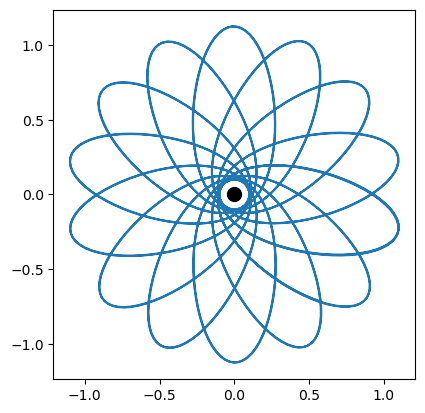

In [16]:
plt.plot(xs[:, 0], xs[:,1])
plt.scatter([0], [0], c="k", s=100)
plt.gca().set_aspect('equal')

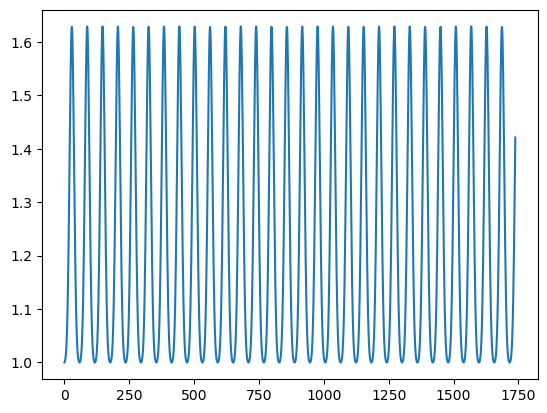

In [17]:
plt.plot(bs)

In [18]:
# Solution using the standard Velocity Verlet

In [19]:
def acceler(x, g):
    
    ret = - x * m_tot / np.linalg.norm(x)**3
    return ret + g(0,x)

def verlet_dkd_step_non_reg(t, x, v,h,g=g_trivial):

    accel = acceler(x, g)
    x_1 = x + v*h + accel*(0.5* h * h) 
    accel_1 = acceler(x_1, g)
    v_1 = v + 0.5*(accel + accel_1)*h
    t_1 = t + h
    
    E = 0.5 * np.sum(v**2) - m_tot / np.linalg.norm(x)
    return t_1, x_1, v_1, E

# Plotting the orbits using the ordinary Verlet

[-0.1 -0.   0. ]
[ 0.       -6.164414  0.      ]
[0. 0. 0. ... 0. 0. 0.]


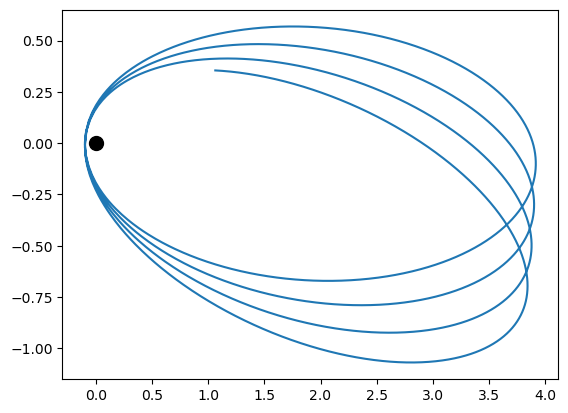

In [20]:
g = g_trivial
t = 0
xs, vs, ts, Es = [], [], [], []
h = 0.01
t_f = 50

x_init = gen_pos(m1,m2,a,ecc,fase,G)
v_init = gen_vel(m1,m2,a,ecc,fase,G) 

x = x_init[0, :] - x_init[1, :]
v = v_init[0, :] - v_init[1, :]
print(x)
print(v)

while t < t_f:
    t, x, v, E = verlet_dkd_step_non_reg(t, x, v, h, g_trivial)
    ts.append(t)
    xs.append(x)
    vs.append(v)
    Es.append(E)

xs = np.array(xs)
vs = np.array(vs)
ts = np.array(ts)
print(xs[:,2])
plt.plot(xs[:, 0], xs[:,1] )
plt.scatter([0], [0], c="k", s=100)


# Checking the conservation of energy for the ordinary verlet

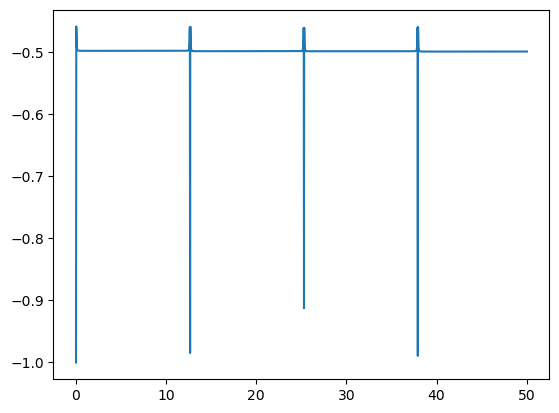

In [21]:
plt.plot(ts, Es)

Text(0.5, 0, 'Time')

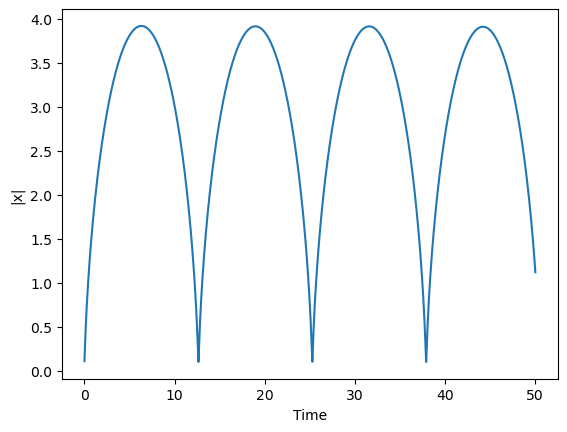

In [22]:
plt.plot(ts, np.linalg.norm(xs, axis=1))
plt.ylabel("|x|")
plt.xlabel("Time")

# Now, a perturbed solution using the ordinary Verlet

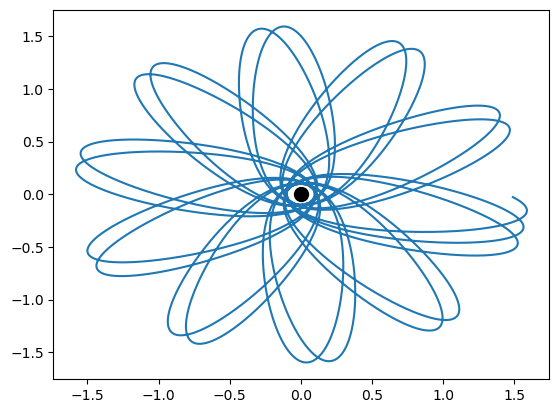

In [23]:
t = 0
xs, vs, ts, Es = [], [], [], []
h = 0.01
t_f = 50

x_init = gen_pos(m1,m2,a,ecc,fase,G)
v_init = gen_vel(m1,m2,a,ecc,fase,G) 

x = x_init[0, :] - x_init[1, :]
v = v_init[0, :] - v_init[1, :]


while t < t_f:
    t, x, v, E = verlet_dkd_step_non_reg(t, x, v, h, g_perturbed)
    ts.append(t)
    xs.append(x)
    vs.append(v)
    Es.append(E)

xs = np.array(xs)
vs = np.array(vs)
ts = np.array(ts)
plt.plot(xs[:, 0], xs[:,1] )
plt.scatter([0], [0], c="k", s=100)
